# CNN Color Image Classification — learner-first notebook (re-written)

This notebook is a **hands-on, step-by-step** rewrite of the attached CNN image-classification lab.

Key goals:
- See what a **color image** is (RGB planes) and how pixel values change with **normalization**.
- Visualize outputs after each **CNN operation** (Conv2D → ReLU → Pooling) and inspect **feature maps**.
- Train a small CNN, evaluate it, and interpret **confusion matrix** + metrics.

> Tip for the session: early cells are intentionally tiny so learners can type them easily.


## 0) Dataset download (one cell)

This lab uses **CIFAR-10** by default because it downloads automatically and is perfect for CNN demos.

If you want to use **your own dataset** (folder with class subfolders), see the optional cell in Section 1B.

In [1]:
import os, math, numpy as np; import matplotlib.pyplot as plt
from pathlib import Path; print('Imports OK ✅')

Imports OK ✅


In [2]:
import torch; import torch.nn as nn; import torch.nn.functional as F
from torch.utils.data import DataLoader; print('PyTorch OK ✅', torch.__version__)

PyTorch OK ✅ 2.4.0+cu118


In [3]:
from torchvision import datasets, transforms
from sklearn.metrics import confusion_matrix, classification_report
print('torchvision + sklearn OK ✅')

torchvision + sklearn OK ✅


In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


## 1A) Download CIFAR-10 and inspect dataset contents + shapes

In [5]:
data_dir = Path('./data')
train_raw = datasets.CIFAR10(root=data_dir, train=True, download=True)
test_raw  = datasets.CIFAR10(root=data_dir, train=False, download=True)
print('Sizes:', len(train_raw), len(test_raw))

100%|███████████████████████████████████████████████████████████████| 170498071/170498071 [00:38<00:00, 4417026.00it/s]


Extracting data\cifar-10-python.tar.gz to data
Files already downloaded and verified
Sizes: 50000 10000


In [6]:
class_names = train_raw.classes
print('Classes:', class_names)
print('Num classes:', len(class_names))

Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
Num classes: 10


In [7]:
img0, y0 = train_raw[0]
arr0 = np.array(img0)
print('One sample -> image shape:', arr0.shape, '| label:', y0, class_names[y0])

One sample -> image shape: (32, 32, 3) | label: 6 frog


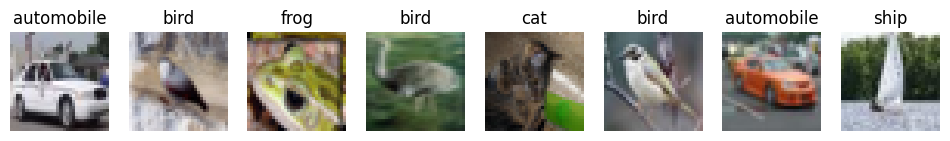

In [8]:
idx = np.random.choice(len(train_raw), 8, replace=False)
plt.figure(figsize=(12,3))
for i,k in enumerate(idx): img,y=train_raw[k]; plt.subplot(1,8,i+1); plt.imshow(img); plt.axis('off'); plt.title(class_names[y])
plt.show()

## 1B) Optional: switch to your own dataset (folder of class subfolders)
Your folder structure should look like:
```
my_dataset/
  train/
    class_0/...
    class_1/...
  test/
    class_0/...
    class_1/...
```
If you're using your own dataset, set `USE_CUSTOM=True` and `CUSTOM_DIR` below.

In [9]:
USE_CUSTOM = False
CUSTOM_DIR = Path('./my_dataset')
print('USE_CUSTOM =', USE_CUSTOM, '| CUSTOM_DIR =', CUSTOM_DIR.resolve())

USE_CUSTOM = False | CUSTOM_DIR = C:\Users\Dr.PVVK\dna_2026\my_dataset


## 2) What is a color image? (RGB planes)

In [10]:
img, y = train_raw[np.random.randint(len(train_raw))]
arr = np.array(img)
print('Image:', arr.shape, arr.dtype, '| label:', class_names[y])

Image: (32, 32, 3) uint8 | label: frog


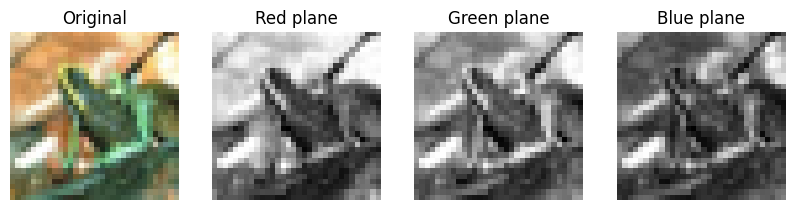

In [11]:
plt.figure(figsize=(10,3))
for i,t in enumerate(['Original','Red plane','Green plane','Blue plane']): plt.subplot(1,4,i+1); plt.imshow(arr if i==0 else arr[:,:,i-1], cmap=None if i==0 else 'gray'); plt.title(t); plt.axis('off')
plt.show()

## 3) Image properties for learning (resolution, pixel ranges, memory)

In [12]:
H,W,C = arr.shape; print('Resolution (H,W,C):', (H,W,C))
print('Pixel range (0..255):', int(arr.min()), 'to', int(arr.max()))
print('Approx memory:', arr.nbytes, 'bytes')

Resolution (H,W,C): (32, 32, 3)
Pixel range (0..255): 12 to 255
Approx memory: 3072 bytes


In [13]:
print('Top-left 3x3 pixels (RGB):')
print(arr[:3,:3,:])

Top-left 3x3 pixels (RGB):
[[[238 220 182]
  [226 210 172]
  [246 230 184]]

 [[226 210 175]
  [232 214 177]
  [233 213 174]]

 [[215 193 154]
  [221 192 151]
  [224 194 156]]]


## 4) Normalization: pixel values before vs after
In CNNs, we usually convert pixels from **0..255** to **0..1**, then (optionally) standardize using `Normalize(mean, std)`.

In [14]:
to_tensor = transforms.ToTensor()
x01 = to_tensor(img)  # (C,H,W) in 0..1
print('Tensor:', tuple(x01.shape), '| range:', float(x01.min()), 'to', float(x01.max()))

Tensor: (3, 32, 32) | range: 0.0470588244497776 to 1.0


In [15]:
mean, std = (0.4914,0.4822,0.4465), (0.2470,0.2435,0.2616)
norm = transforms.Normalize(mean, std)
xN = norm(x01)
print('After Normalize -> range:', float(xN.min()), 'to', float(xN.max()))

After Normalize -> range: -1.6878145933151245 to 2.12648868560791


In [16]:
print('Before norm (C=0) 3x3 patch:\n', x01[0,:3,:3])
print('After  norm (C=0) 3x3 patch:\n', xN[0,:3,:3])

Before norm (C=0) 3x3 patch:
 tensor([[0.9333, 0.8863, 0.9647],
        [0.8863, 0.9098, 0.9137],
        [0.8431, 0.8667, 0.8784]])
After  norm (C=0) 3x3 patch:
 tensor([[1.7892, 1.5987, 1.9162],
        [1.5987, 1.6939, 1.7098],
        [1.4240, 1.5193, 1.5669]])


## 5) Padding (why it matters)
Padding can preserve spatial size during convolution or help fit model input size. Here we show a manual padding example.

In [17]:
x_pad = F.pad(x01, pad=(2,2,2,2), mode='constant', value=0.0)
print('Original:', tuple(x01.shape), '-> Padded:', tuple(x_pad.shape))
print('Padded border pixel (top-left):', float(x_pad[0,0,0]))

Original: (3, 32, 32) -> Padded: (3, 36, 36)
Padded border pixel (top-left): 0.0


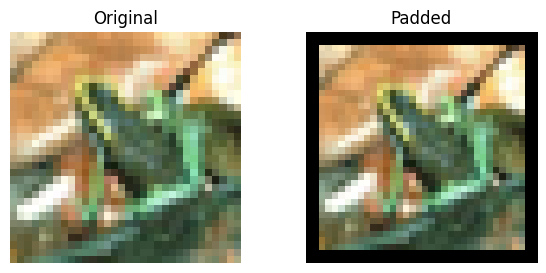

In [18]:
plt.figure(figsize=(7,3))
plt.subplot(1,2,1); plt.imshow(x01.permute(1,2,0)); plt.title('Original'); plt.axis('off')
plt.subplot(1,2,2); plt.imshow(x_pad.permute(1,2,0)); plt.title('Padded'); plt.axis('off')
plt.show()

## 6) Prepare train/test data (what the model expects)
A CNN expects a 4D tensor: **(batch, channels, height, width)**.

We'll build train/test datasets with transforms and show a batch shape.

In [19]:
train_tf = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean,std)])
test_tf  = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean,std)])
train_ds = datasets.CIFAR10(root=data_dir, train=True,  download=True, transform=train_tf)
test_ds  = datasets.CIFAR10(root=data_dir, train=False, download=True, transform=test_tf)

Files already downloaded and verified
Files already downloaded and verified


In [20]:
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=64, shuffle=False, num_workers=2, pin_memory=True)
xb, yb = next(iter(train_loader))
print('Batch X:', tuple(xb.shape), '| Batch y:', tuple(yb.shape))

Batch X: (64, 3, 32, 32) | Batch y: (64,)


## 7) Build a tiny CNN (easy to explain in an interview)

In [21]:
model = nn.Sequential(nn.Conv2d(3,16,3,stride=1,padding=1), nn.ReLU(), nn.MaxPool2d(2), nn.Conv2d(16,32,3,stride=1,padding=1), nn.ReLU(), nn.MaxPool2d(2), nn.Flatten(), nn.Linear(32*8*8,128), nn.ReLU(), nn.Linear(128,10)).to(device)
print(model)

Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=2048, out_features=128, bias=True)
  (8): ReLU()
  (9): Linear(in_features=128, out_features=10, bias=True)
)


### 7A) Model “architecture table” (input/output shapes, kernel, stride, padding, parameters)

In [22]:
x = torch.zeros(1,3,32,32).to(device)
for layer in model: y=layer(x); p=sum(pp.numel() for pp in layer.parameters()); k=getattr(layer,'kernel_size',None); s=getattr(layer,'stride',None); pad=getattr(layer,'padding',None); print(f"{layer.__class__.__name__:>10} | {tuple(x.shape)} -> {tuple(y.shape)} | k={k} s={s} pad={pad} | params={p}"); x=y
print('Total parameters:', sum(p.numel() for p in model.parameters()))

    Conv2d | (1, 3, 32, 32) -> (1, 16, 32, 32) | k=(3, 3) s=(1, 1) pad=(1, 1) | params=448
      ReLU | (1, 16, 32, 32) -> (1, 16, 32, 32) | k=None s=None pad=None | params=0
 MaxPool2d | (1, 16, 32, 32) -> (1, 16, 16, 16) | k=2 s=2 pad=0 | params=0
    Conv2d | (1, 16, 16, 16) -> (1, 32, 16, 16) | k=(3, 3) s=(1, 1) pad=(1, 1) | params=4640
      ReLU | (1, 32, 16, 16) -> (1, 32, 16, 16) | k=None s=None pad=None | params=0
 MaxPool2d | (1, 32, 16, 16) -> (1, 32, 8, 8) | k=2 s=2 pad=0 | params=0
   Flatten | (1, 32, 8, 8) -> (1, 2048) | k=None s=None pad=None | params=0
    Linear | (1, 2048) -> (1, 128) | k=None s=None pad=None | params=262272
      ReLU | (1, 128) -> (1, 128) | k=None s=None pad=None | params=0
    Linear | (1, 128) -> (1, 10) | k=None s=None pad=None | params=1290
Total parameters: 268650


## 8) Visualize CNN operations on ONE image
We will pass one image through: **Conv → ReLU → Pool → Conv → ReLU → Pool** and display shapes + feature maps.

Note: the visualizations are most meaningful **after training**, but we can still inspect the mechanics now.

In [23]:
def plot_maps(t, n=8, title=''): t=t.detach().cpu(); plt.figure(figsize=(12,3)); [plt.subplot(1,n,i+1) or plt.imshow(t[0,i], cmap='gray') or plt.axis('off') for i in range(n)]; plt.suptitle(title); plt.show()
print('Helper plot_maps() ready ✅')

Helper plot_maps() ready ✅


Input to CNN: (1, 3, 32, 32) | true label: cat


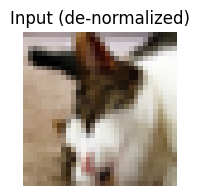

In [24]:
img_t, y_t = train_ds[np.random.randint(len(train_ds))]
x1 = img_t.unsqueeze(0).to(device)
print('Input to CNN:', tuple(x1.shape), '| true label:', class_names[y_t])
plt.figure(figsize=(2,2)); plt.imshow(img_t.cpu().permute(1,2,0)*torch.tensor(std)+torch.tensor(mean)); plt.axis('off'); plt.title('Input (de-normalized)'); plt.show()

Conv1: k= (3, 3) s= (1, 1) pad= (1, 1) | (1, 3, 32, 32) -> (1, 16, 32, 32)
Conv1 sample values (filter0, 3x3):
 tensor([[-0.1494, -0.1481, -0.1382],
        [-0.1859,  0.0162,  0.0712],
        [-0.2261,  0.5650,  0.7422]])


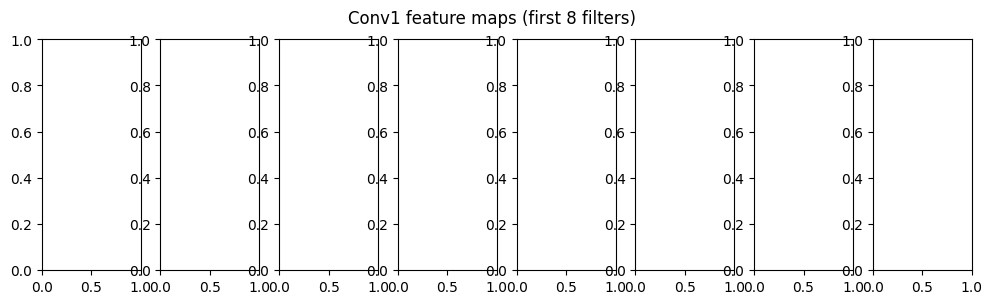

In [25]:
conv1 = model[0]; z1 = conv1(x1)
print('Conv1:', 'k=', conv1.kernel_size, 's=', conv1.stride, 'pad=', conv1.padding, '|', tuple(x1.shape), '->', tuple(z1.shape))
print('Conv1 sample values (filter0, 3x3):\n', z1[0,0,:3,:3].detach().cpu())
plot_maps(z1, n=8, title='Conv1 feature maps (first 8 filters)')

ReLU1: (1, 16, 32, 32) -> (1, 16, 32, 32) | min/max: 0.0 3.26417875289917
ReLU1 sample values (filter0, 3x3):
 tensor([[0.0000, 0.0000, 0.0000],
        [0.0000, 0.0162, 0.0712],
        [0.0000, 0.5650, 0.7422]])


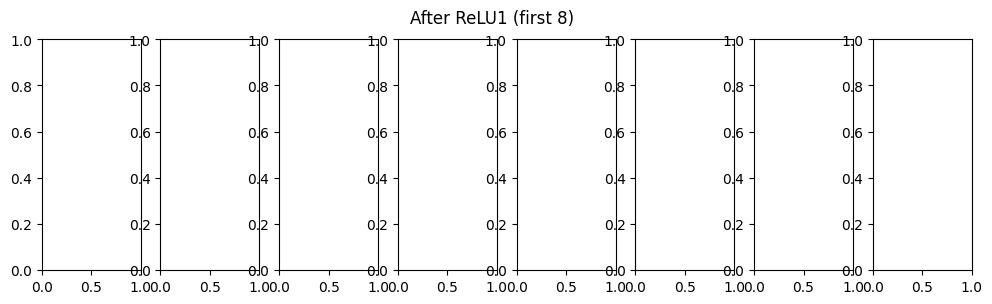

In [26]:
relu1 = model[1]; a1 = relu1(z1)
print('ReLU1:', tuple(z1.shape), '->', tuple(a1.shape), '| min/max:', float(a1.min()), float(a1.max()))
print('ReLU1 sample values (filter0, 3x3):\n', a1[0,0,:3,:3].detach().cpu())
plot_maps(a1, n=8, title='After ReLU1 (first 8)')

Pool1: k= 2 s= 2 pad= 0 | (1, 16, 32, 32) -> (1, 16, 16, 16)
Pool1 sample values (filter0, 3x3):
 tensor([[0.0162, 0.0712, 0.0408],
        [0.8288, 1.0915, 1.0131],
        [0.8233, 0.7211, 0.7954]])


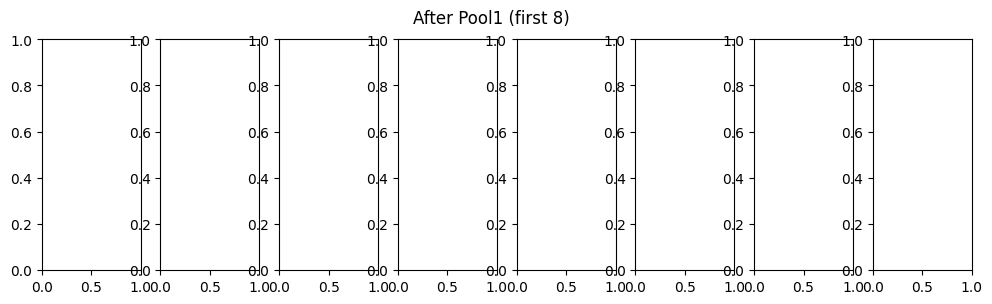

In [27]:
pool1 = model[2]; p1 = pool1(a1)
print('Pool1:', 'k=', pool1.kernel_size, 's=', pool1.stride, 'pad=', pool1.padding, '|', tuple(a1.shape), '->', tuple(p1.shape))
print('Pool1 sample values (filter0, 3x3):\n', p1[0,0,:3,:3].detach().cpu())
plot_maps(p1, n=8, title='After Pool1 (first 8)')

Conv2: k= (3, 3) s= (1, 1) pad= (1, 1) | (1, 16, 16, 16) -> (1, 32, 16, 16)
Conv2 sample values (filter0, 3x3):
 tensor([[-0.0209, -0.1082, -0.1863],
        [-0.0808, -0.2550, -0.1691],
        [ 0.0065, -0.0868,  0.1478]])


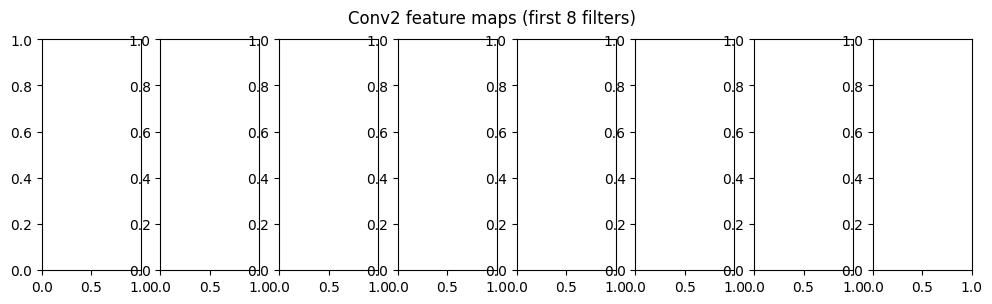

In [28]:
conv2 = model[3]; z2 = conv2(p1)
print('Conv2:', 'k=', conv2.kernel_size, 's=', conv2.stride, 'pad=', conv2.padding, '|', tuple(p1.shape), '->', tuple(z2.shape))
print('Conv2 sample values (filter0, 3x3):\n', z2[0,0,:3,:3].detach().cpu())
plot_maps(z2, n=8, title='Conv2 feature maps (first 8 filters)')

ReLU2: (1, 32, 16, 16) -> (1, 32, 16, 16) | min/max: 0.0 1.2751104831695557
ReLU2 sample values (filter0, 3x3):
 tensor([[0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000],
        [0.0065, 0.0000, 0.1478]])


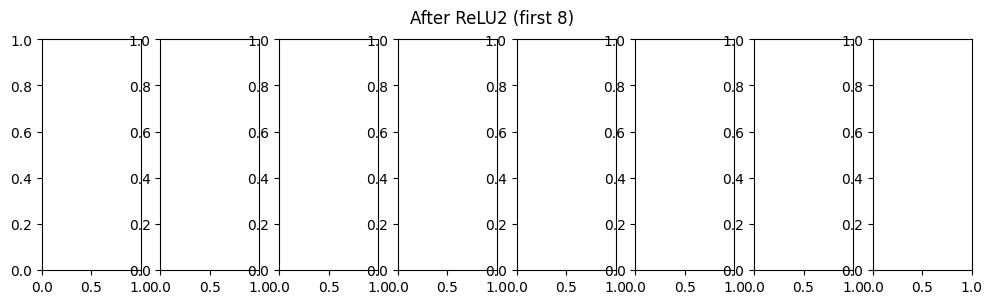

In [29]:
relu2 = model[4]; a2 = relu2(z2)
print('ReLU2:', tuple(z2.shape), '->', tuple(a2.shape), '| min/max:', float(a2.min()), float(a2.max()))
print('ReLU2 sample values (filter0, 3x3):\n', a2[0,0,:3,:3].detach().cpu())
plot_maps(a2, n=8, title='After ReLU2 (first 8)')

Pool2: k= 2 s= 2 pad= 0 | (1, 32, 16, 16) -> (1, 32, 8, 8)
Pool2 sample values (filter0, 3x3):
 tensor([[0.0000, 0.0000, 0.0000],
        [0.0065, 0.2080, 0.1178],
        [0.0884, 0.0756, 0.0301]])


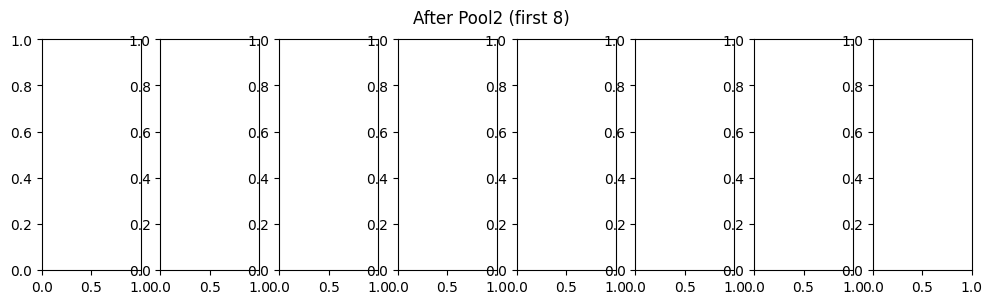

In [30]:
pool2 = model[5]; p2 = pool2(a2)
print('Pool2:', 'k=', pool2.kernel_size, 's=', pool2.stride, 'pad=', pool2.padding, '|', tuple(a2.shape), '->', tuple(p2.shape))
print('Pool2 sample values (filter0, 3x3):\n', p2[0,0,:3,:3].detach().cpu())
plot_maps(p2, n=8, title='After Pool2 (first 8)')

## 9) Train the model (show loss + accuracy during training)
We train with CrossEntropyLoss (includes softmax internally). We print **train loss/acc** and **test loss/acc** each epoch.

In [31]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
EPOCHS = 5; print('Ready to train for', EPOCHS, 'epochs')

Ready to train for 5 epochs


In [32]:
train_step = lambda xb,yb: (lambda xb,yb: (optimizer.zero_grad(), (out:=model(xb)), (loss:=criterion(out,yb)), loss.backward(), optimizer.step(), loss.item()*xb.size(0), (out.argmax(1)==yb).sum().item(), yb.size(0))[-3:])(xb.to(device), yb.to(device))
eval_step  = lambda xb,yb: (lambda xb,yb: (torch.set_grad_enabled(False), (out:=model(xb)), (loss:=criterion(out,yb)), torch.set_grad_enabled(True), loss.item()*xb.size(0), (out.argmax(1)==yb).sum().item(), yb.size(0))[-3:])(xb.to(device), yb.to(device))
print('train_step/eval_step ready ✅')

train_step/eval_step ready ✅


In [33]:
hist={'tr_loss':[],'tr_acc':[],'te_loss':[],'te_acc':[]}
for ep in range(1,EPOCHS+1): tr=[train_step(xb,yb) for xb,yb in train_loader]; te=[eval_step(xb,yb) for xb,yb in test_loader]; tl,tc,tn=map(sum,zip(*tr)); vl,vc,vn=map(sum,zip(*te)); hist['tr_loss']+=[tl/tn]; hist['tr_acc']+=[tc/tn]; hist['te_loss']+=[vl/vn]; hist['te_acc']+=[vc/vn]; print(f"Epoch {ep:02d} | train loss/acc {tl/tn:.4f}/{tc/tn:.3f} | test loss/acc {vl/vn:.4f}/{vc/vn:.3f}")

Epoch 01 | train loss/acc 1.3812/0.506 | test loss/acc 1.2036/0.562
Epoch 02 | train loss/acc 1.0423/0.631 | test loss/acc 0.9837/0.656
Epoch 03 | train loss/acc 0.8957/0.685 | test loss/acc 0.9432/0.668
Epoch 04 | train loss/acc 0.7921/0.721 | test loss/acc 0.9017/0.683
Epoch 05 | train loss/acc 0.7007/0.754 | test loss/acc 0.8816/0.693


## 10) Plot training curves (loss and accuracy)

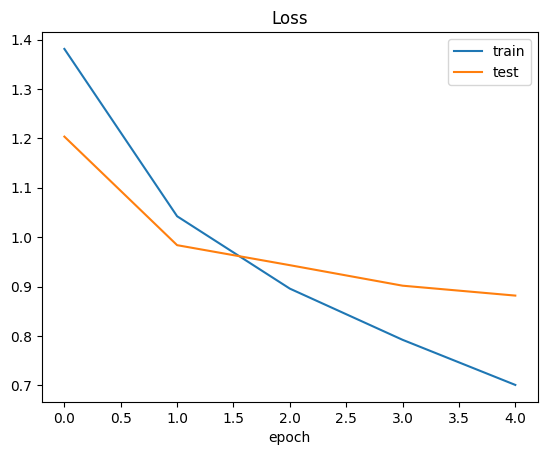

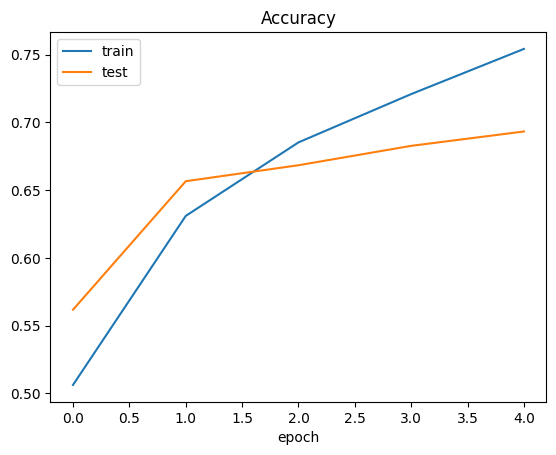

In [34]:
plt.figure(); plt.plot(hist['tr_loss'], label='train'); plt.plot(hist['te_loss'], label='test'); plt.title('Loss'); plt.xlabel('epoch'); plt.legend(); plt.show()
plt.figure(); plt.plot(hist['tr_acc'], label='train'); plt.plot(hist['te_acc'], label='test'); plt.title('Accuracy'); plt.xlabel('epoch'); plt.legend(); plt.show()

## 11) Test the model: predictions + confidence + sample visualization
**Confidence** here is shown as:
- `max_prob`: highest softmax probability
- `margin`: difference between top-1 and top-2 probabilities (bigger margin → more confident)

In [35]:
model.eval(); xb, yb = next(iter(test_loader)); xb, yb = xb.to(device), yb.to(device)
with torch.no_grad(): logits = model(xb); probs = torch.softmax(logits, dim=1)
top2 = probs.topk(2, dim=1); max_prob = top2.values[:,0]; margin = top2.values[:,0]-top2.values[:,1]
print('Example confidence (first 10):'); print(torch.stack([max_prob[:10], margin[:10]], dim=1).detach().cpu())

Example confidence (first 10):
tensor([[0.8351, 0.7184],
        [0.7635, 0.5362],
        [0.5923, 0.4022],
        [0.8396, 0.7797],
        [0.8642, 0.7946],
        [0.8592, 0.7764],
        [0.9967, 0.9956],
        [0.7514, 0.6311],
        [0.6831, 0.4966],
        [0.9026, 0.8131]])


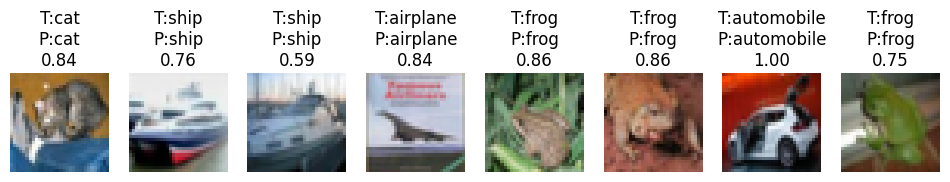

In [36]:
n=8; imgs=xb[:n].detach().cpu(); true=yb[:n].detach().cpu(); pred=probs.argmax(1)[:n].detach().cpu(); conf=max_prob[:n].detach().cpu()
plt.figure(figsize=(12,3))
for i in range(n): im=imgs[i].permute(1,2,0)*torch.tensor(std)+torch.tensor(mean); plt.subplot(1,n,i+1); plt.imshow(im.clamp(0,1)); plt.axis('off'); plt.title(f"T:{class_names[true[i]]}\nP:{class_names[pred[i]]}\n{conf[i]:.2f}")
plt.show()

## 12) Confusion matrix + classification report
A confusion matrix shows **actual (rows)** vs **predicted (columns)** counts for each class.

In [37]:
y_true, y_pred = [], []
with torch.no_grad():
    for xb,yb in test_loader: xb=xb.to(device); y_true += yb.tolist(); y_pred += model(xb).argmax(1).detach().cpu().tolist()
cm = confusion_matrix(y_true, y_pred); print('Confusion matrix shape:', cm.shape)

Confusion matrix shape: (10, 10)


In [38]:
print(classification_report(y_true, y_pred, target_names=class_names))
print('Total test samples:', len(y_true), '| Correct:', int(np.trace(cm)))

              precision    recall  f1-score   support

    airplane       0.74      0.74      0.74      1000
  automobile       0.82      0.79      0.80      1000
        bird       0.54      0.59      0.56      1000
         cat       0.57      0.40      0.47      1000
        deer       0.56      0.71      0.62      1000
         dog       0.63      0.58      0.61      1000
        frog       0.74      0.82      0.78      1000
       horse       0.74      0.75      0.75      1000
        ship       0.83      0.80      0.81      1000
       truck       0.77      0.76      0.77      1000

    accuracy                           0.69     10000
   macro avg       0.69      0.69      0.69     10000
weighted avg       0.69      0.69      0.69     10000

Total test samples: 10000 | Correct: 6932


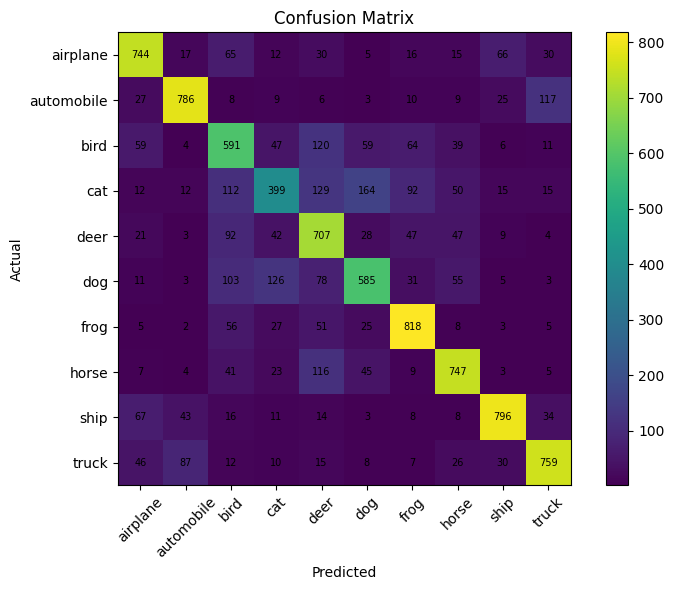

In [39]:
plt.figure(figsize=(8,6)); plt.imshow(cm); plt.title('Confusion Matrix'); plt.xlabel('Predicted'); plt.ylabel('Actual'); plt.colorbar()
plt.xticks(range(10), class_names, rotation=45); plt.yticks(range(10), class_names)
[plt.text(j,i,cm[i,j],ha='center',va='center',fontsize=7) for i in range(10) for j in range(10)]
plt.tight_layout(); plt.show()

### 12A) How many were tested vs predicted correctly in each class?
For each class:
- `tested` = total items in that class (row sum)
- `correct` = diagonal value
- `class accuracy` = correct / tested

In [40]:
tested = cm.sum(axis=1); correct = np.diag(cm)
acc = np.divide(correct, tested, out=np.zeros_like(correct, dtype=float), where=tested!=0)
for i,name in enumerate(class_names): print(f"{name:>10} | tested={tested[i]:4d} | correct={correct[i]:4d} | acc={acc[i]:.3f}")
print('Overall accuracy:', correct.sum()/tested.sum())

  airplane | tested=1000 | correct= 744 | acc=0.744
automobile | tested=1000 | correct= 786 | acc=0.786
      bird | tested=1000 | correct= 591 | acc=0.591
       cat | tested=1000 | correct= 399 | acc=0.399
      deer | tested=1000 | correct= 707 | acc=0.707
       dog | tested=1000 | correct= 585 | acc=0.585
      frog | tested=1000 | correct= 818 | acc=0.818
     horse | tested=1000 | correct= 747 | acc=0.747
      ship | tested=1000 | correct= 796 | acc=0.796
     truck | tested=1000 | correct= 759 | acc=0.759
Overall accuracy: 0.6932


## 13) Visualize feature maps AFTER training (what filters learned)
We re-run the earlier Conv1/Conv2 feature map visualization using the **trained model** outputs.
This helps you explain in interviews that early filters learn edges/textures, and deeper ones learn more abstract patterns.

Conv1 output: (1, 16, 32, 32) | Conv2 output: (1, 32, 16, 16)


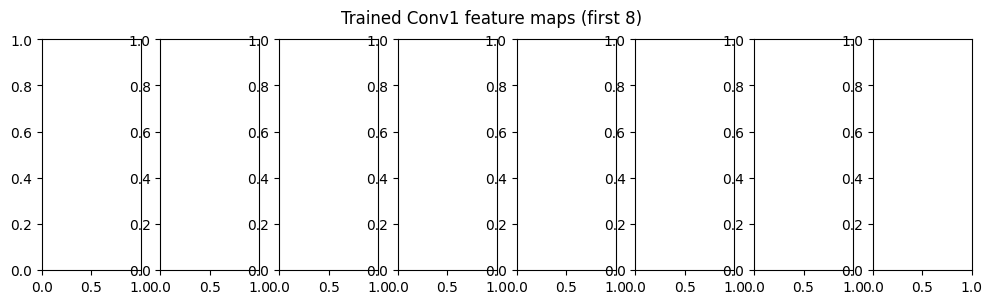

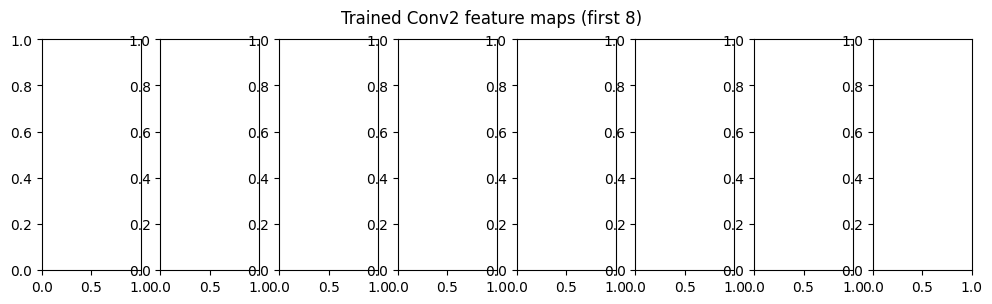

In [41]:
model.eval(); img_t, y_t = test_ds[np.random.randint(len(test_ds))]; x1 = img_t.unsqueeze(0).to(device)
with torch.no_grad(): z1 = model[0](x1); z2 = model[3](model[2](model[1](z1)))
print('Conv1 output:', tuple(z1.shape), '| Conv2 output:', tuple(z2.shape))
plot_maps(z1, n=8, title='Trained Conv1 feature maps (first 8)'); plot_maps(z2, n=8, title='Trained Conv2 feature maps (first 8)')

## 14) Interview-ready concepts (industry patterns)
- **Data leakage**: never fit normalization/standardization on test data.
- **Overfitting**: training accuracy ↑ while test accuracy ↓ (use dropout, augmentation, weight decay, early stopping).
- **Augmentation**: random crop/flip/color jitter improves generalization.
- **Class imbalance**: use weighted loss, resampling, and report per-class metrics (not only overall accuracy).
- **Learning rate**: one of the biggest levers; schedulers (StepLR/Cosine) can improve final accuracy.
- **Transfer learning**: start with pretrained (ResNet/MobileNet) and fine-tune for small datasets.
- **Explainability**: feature maps, saliency maps/Grad-CAM (common interview topic).
- **Deployment basics**: batch vs real-time inference, latency, quantization, ONNX export.

If you want, I can add optional sections for augmentation, dropout, and transfer learning while keeping the early cells tiny.